In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Dataloading and Preprocessing

In [2]:
# Load the datasets (adjust paths as needed)
orders = pd.read_csv('archive/olist_orders_dataset.csv')
items = pd.read_csv('archive/olist_order_items_dataset.csv')
products = pd.read_csv('archive/olist_products_dataset.csv')
sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
customers = pd.read_csv('archive/olist_customers_dataset.csv')

# 1. Merge Orders and Items
df = pd.merge(orders, items, on='order_id')

# 2. Merge with Products (to get weight/dimensions)
df = pd.merge(df, products, on='product_id')

# 3. Merge with Sellers (to get seller location)
df = pd.merge(df, sellers, on='seller_id')

# 4. Merge with Customers (to get delivery location)
df = pd.merge(df, customers, on='customer_id')

# Filter for only 'delivered' orders to train the model
final_df = df[df['order_status'] == 'delivered'].copy()

print(f"Master Dataframe Shape: {df.shape}")
print(f"Final Dataframe Shape: {final_df.shape}")

Master Dataframe Shape: (112650, 29)
Final Dataframe Shape: (110197, 29)


In [3]:
#Merging datasets
def merge_datasets(orders, items, products, sellers, customers):
    print('Merging datasets')
    df = pd.merge(orders, items, on='order_id')
    df = pd.merge(df, products, on='product_id')
    df = pd.merge(df, sellers, on='seller_id')
    df = pd.merge(df, customers, on='customer_id')

    # Filter for only 'delivered' orders to train the model
    final_df = df[df['order_status'] == 'delivered'].copy()

    print('Datasets merged and filtered for delivered orders successfully')

    print(f"Master Dataframe Shape: {df.shape}")
    print(f"Final Dataframe Shape: {final_df.shape}")

    print('='*100)
    return final_df


## Exploratory data Analysis

In [4]:
print('Data information')
final_df.info()
print('-'*50)

print('Data description')
final_df.describe()
print('-'*50)

print('Null values')
final_df.isnull().sum()
print('-'*50)

print('Duplicated values')
final_df.duplicated().sum()




Data information
<class 'pandas.core.frame.DataFrame'>
Index: 110197 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110197 non-null  object 
 1   customer_id                    110197 non-null  object 
 2   order_status                   110197 non-null  object 
 3   order_purchase_timestamp       110197 non-null  object 
 4   order_approved_at              110182 non-null  object 
 5   order_delivered_carrier_date   110195 non-null  object 
 6   order_delivered_customer_date  110189 non-null  object 
 7   order_estimated_delivery_date  110197 non-null  object 
 8   order_item_id                  110197 non-null  int64  
 9   product_id                     110197 non-null  object 
 10  seller_id                      110197 non-null  object 
 11  shipping_limit_date            110197 non-null  object 
 12  price             

--------------------------------------------------
Null values
--------------------------------------------------
Duplicated values


np.int64(0)

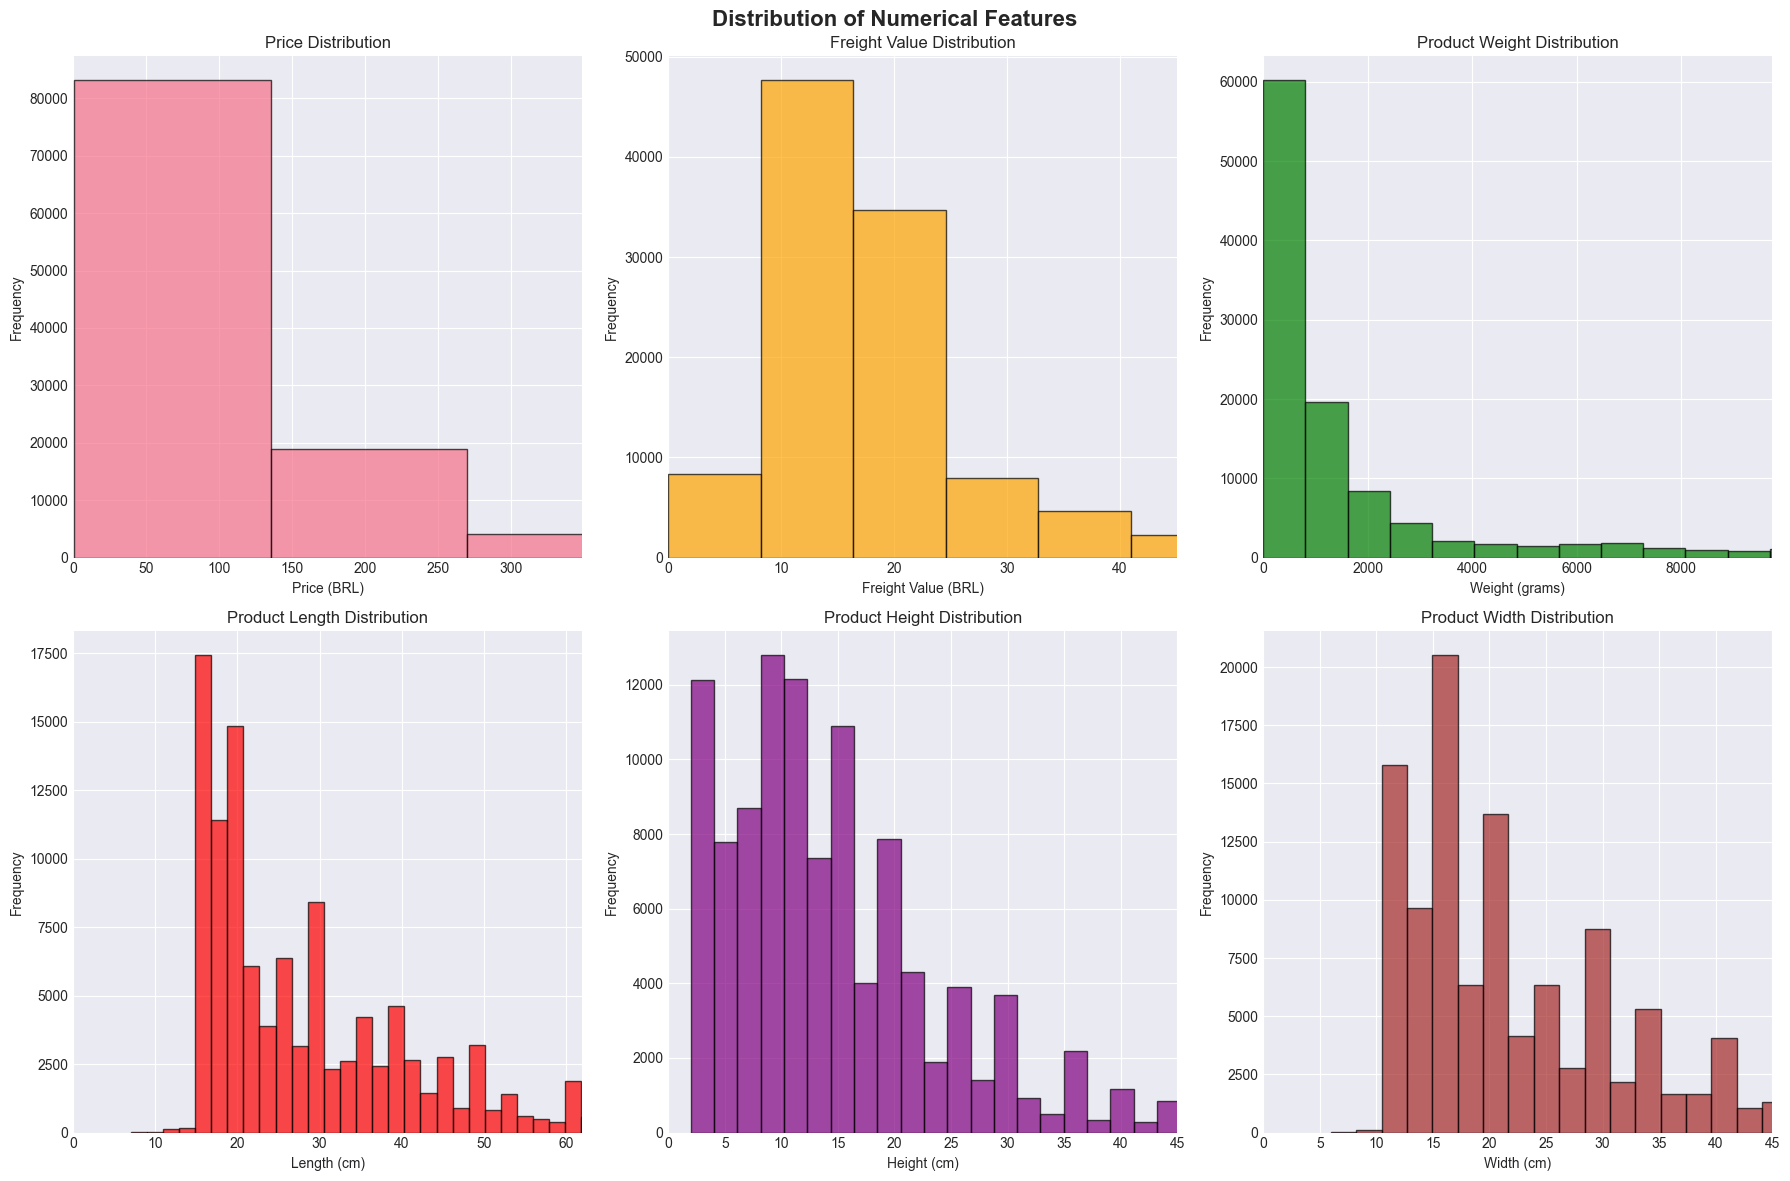

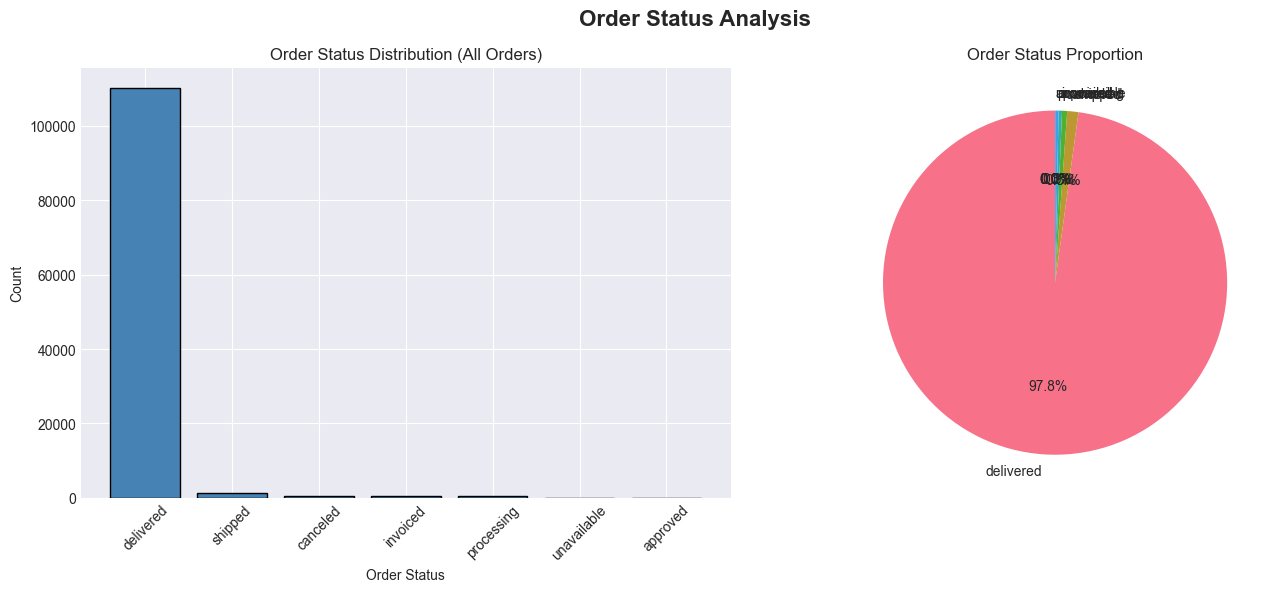

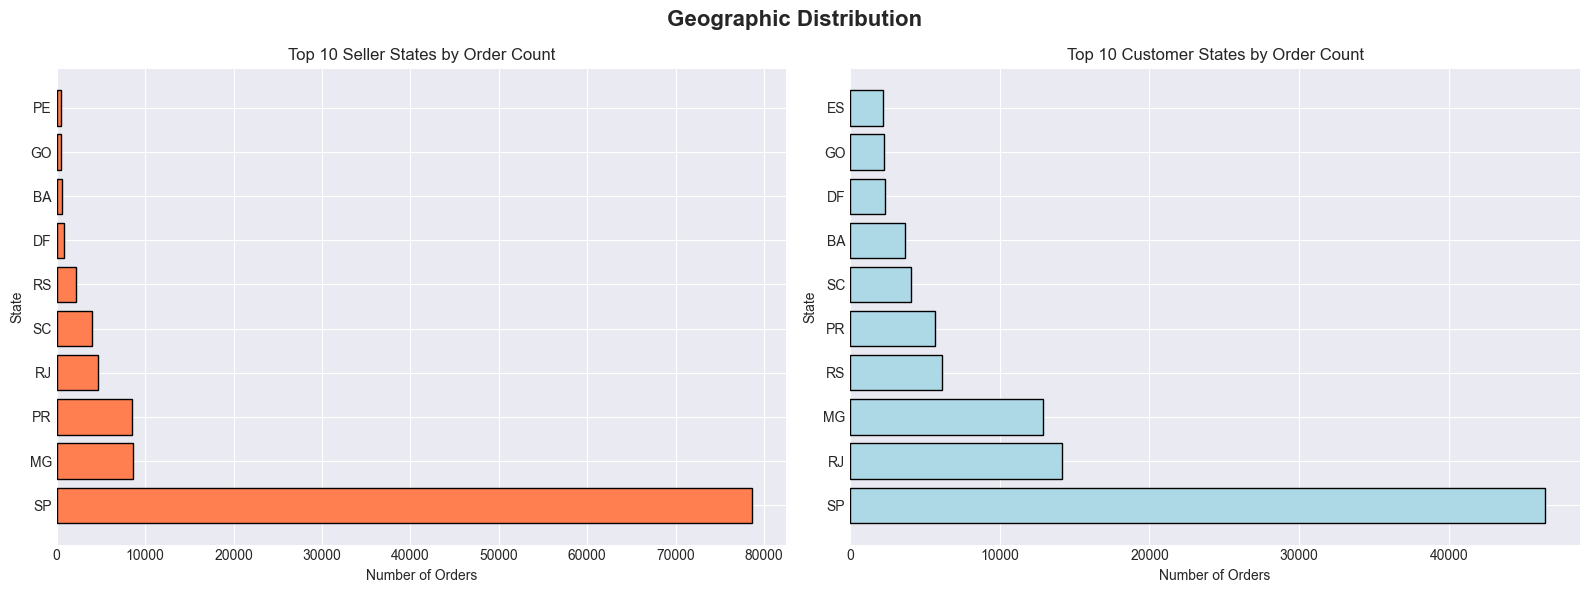

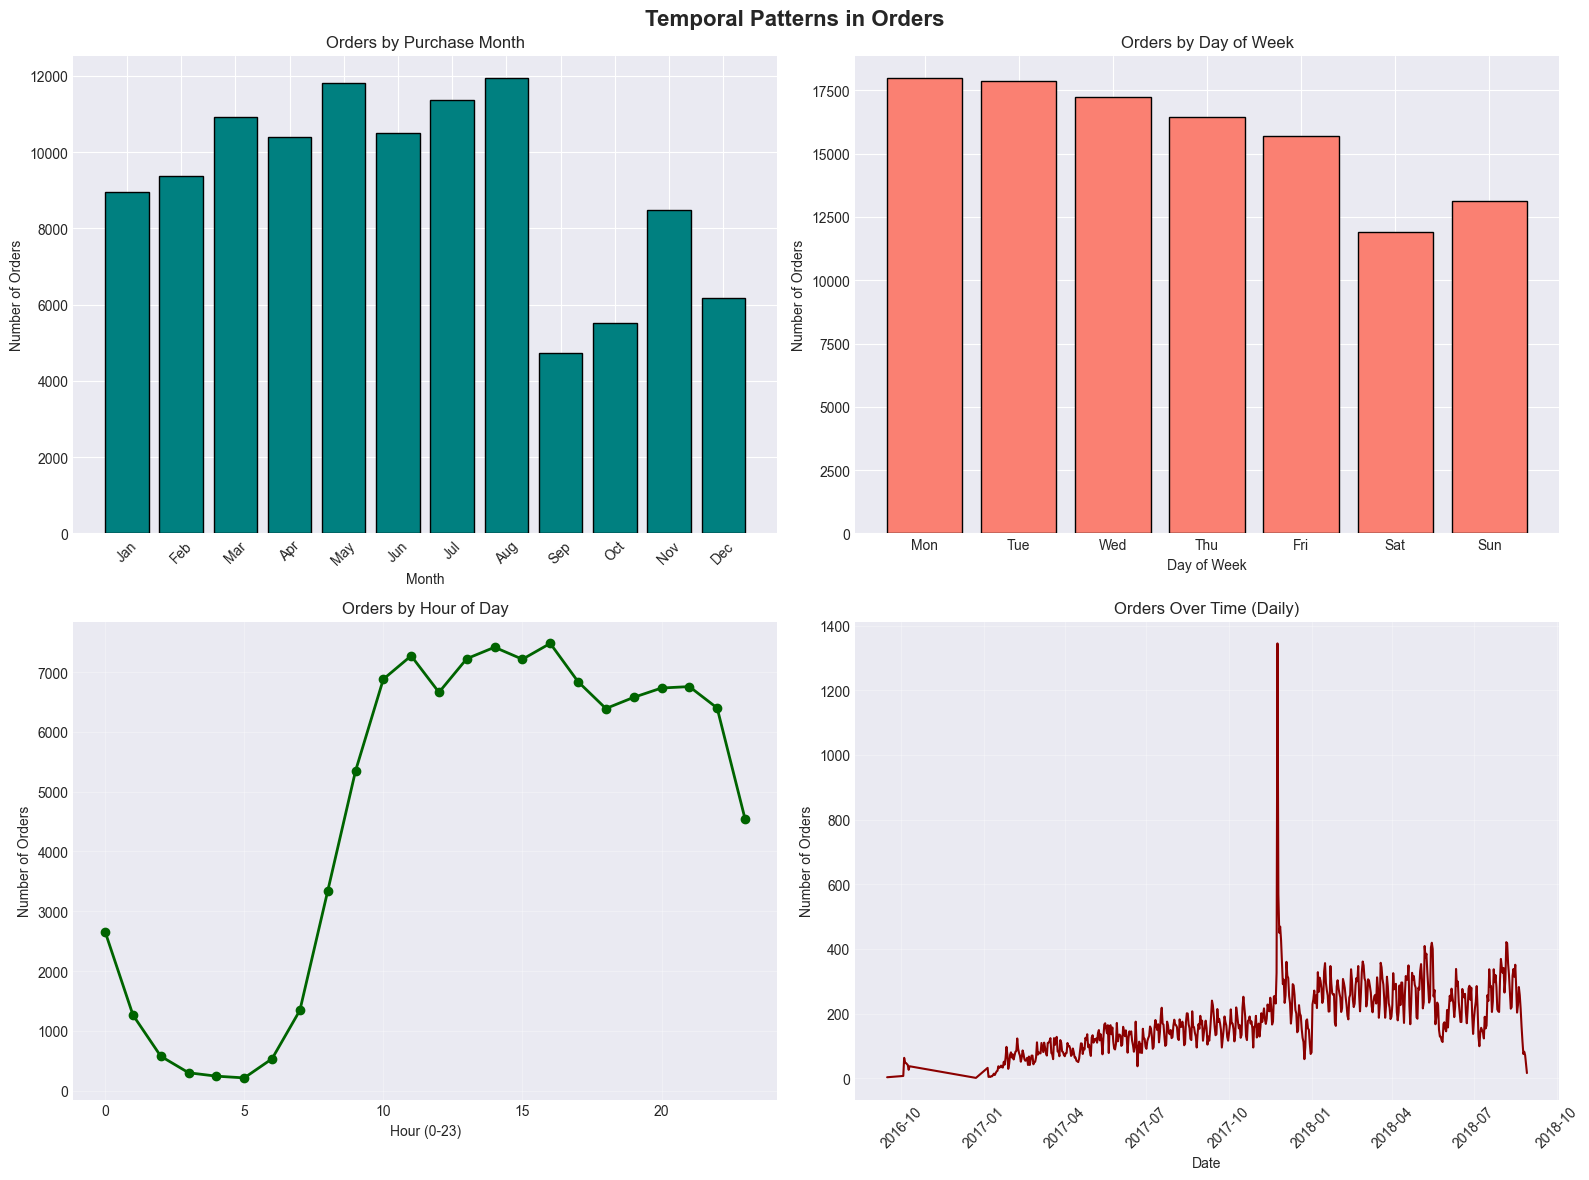

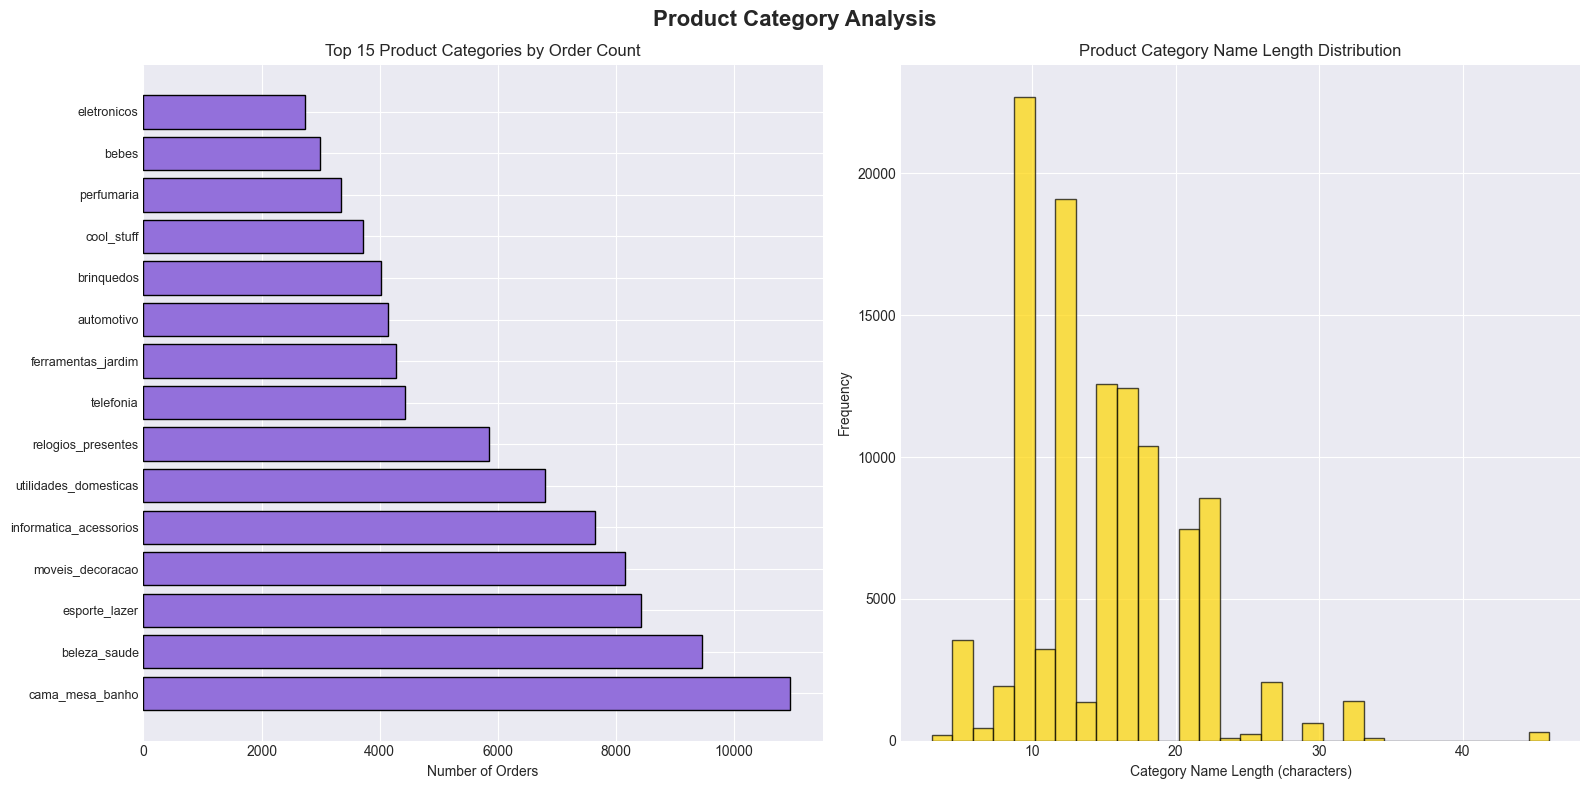

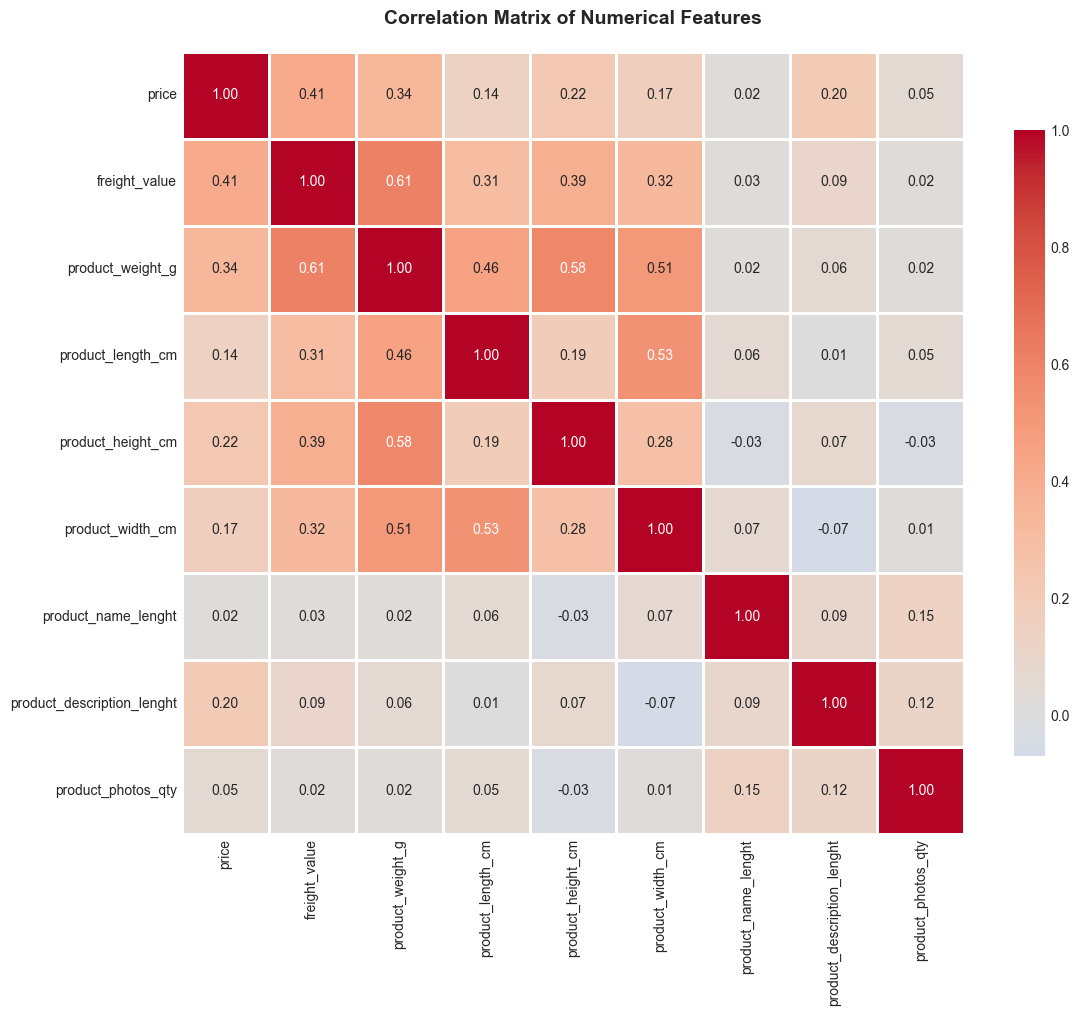

/var/folders/7q/khzztf0d5ybdgh3zk9c2086h0000gp/T/ipykernel_75050/2213435878.py:214: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(product_dims, labels=['Length', 'Height', 'Width'], vert=True)


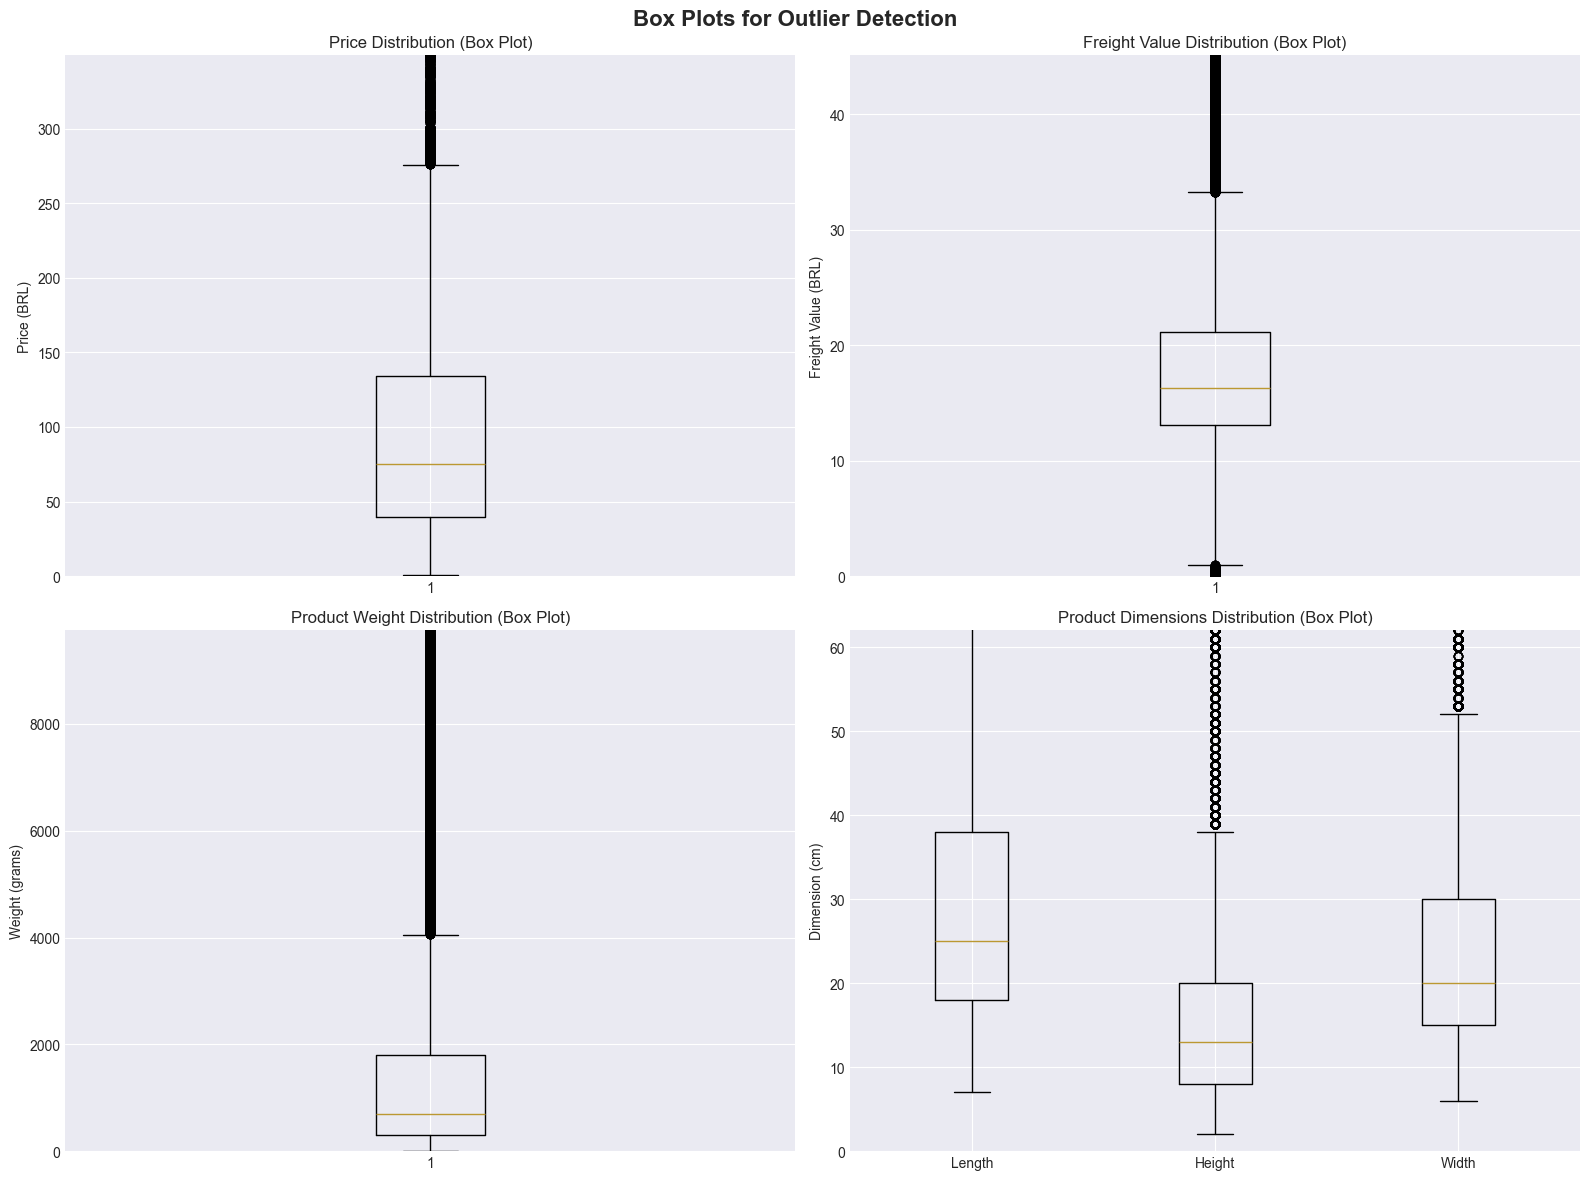

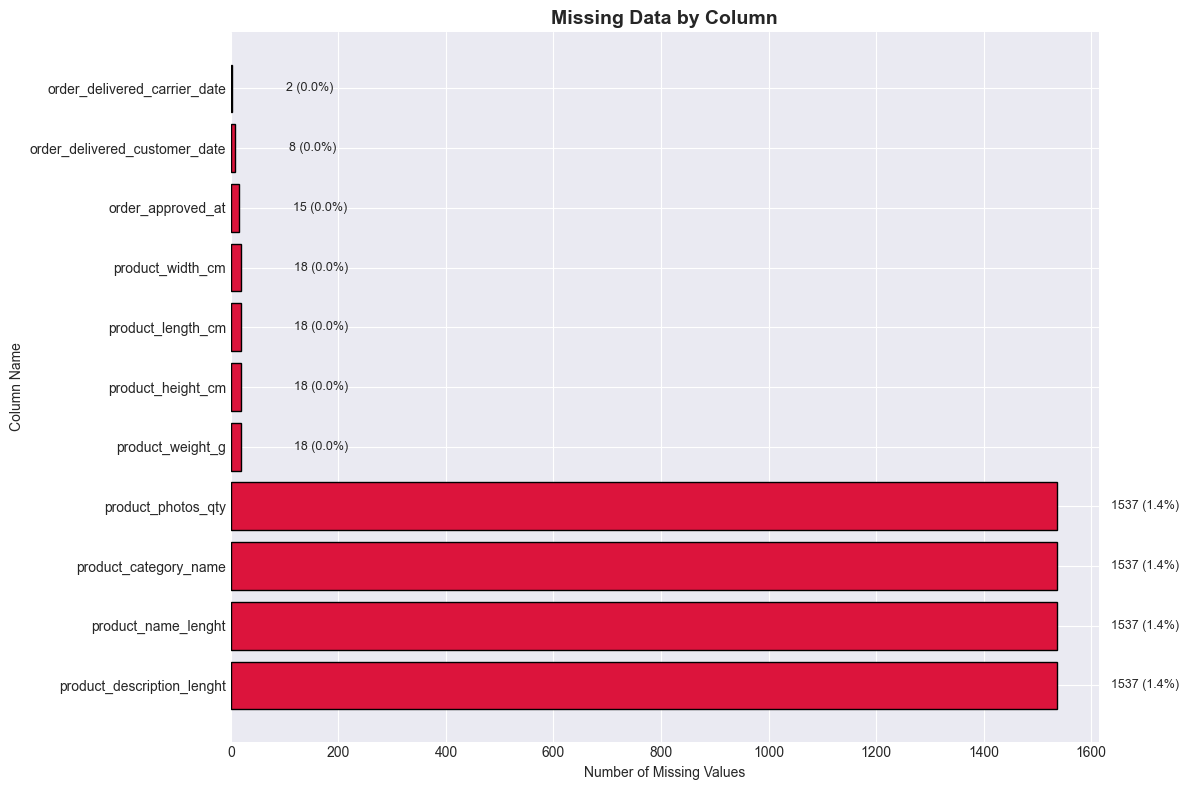

SUMMARY STATISTICS FOR NUMERICAL FEATURES
               price  freight_value  product_weight_g  product_length_cm  \
count  110197.000000  110197.000000     110179.000000      110179.000000   
mean      119.980563      19.948598       2089.680892          30.142541   
std       182.299446      15.698136       3741.605703          16.122277   
min         0.850000       0.000000          0.000000           7.000000   
25%        39.900000      13.080000        300.000000          18.000000   
50%        74.900000      16.260000        700.000000          25.000000   
75%       134.170000      21.150000       1800.000000          38.000000   
max      6735.000000     409.680000      40425.000000         105.000000   

       product_height_cm  product_width_cm  product_name_lenght  \
count      110179.000000     110179.000000        108660.000000   
mean           16.555678         22.986604            48.808559   
std            13.409572         11.688439            10.008243   
min  

In [5]:
#Exploratory Data Analysis Visualizations

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

# Price distribution
axes[0, 0].hist(final_df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (BRL)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(0, final_df['price'].quantile(0.95))  # Remove extreme outliers for better visualization

# Freight value distribution
axes[0, 1].hist(final_df['freight_value'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Freight Value Distribution')
axes[0, 1].set_xlabel('Freight Value (BRL)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(0, final_df['freight_value'].quantile(0.95))

# Product weight distribution
axes[0, 2].hist(final_df['product_weight_g'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Product Weight Distribution')
axes[0, 2].set_xlabel('Weight (grams)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_xlim(0, final_df['product_weight_g'].quantile(0.95))

# Product dimensions
axes[1, 0].hist(final_df['product_length_cm'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_title('Product Length Distribution')
axes[1, 0].set_xlabel('Length (cm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, final_df['product_length_cm'].quantile(0.95))

axes[1, 1].hist(final_df['product_height_cm'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Product Height Distribution')
axes[1, 1].set_xlabel('Height (cm)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, final_df['product_height_cm'].quantile(0.95))

axes[1, 2].hist(final_df['product_width_cm'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[1, 2].set_title('Product Width Distribution')
axes[1, 2].set_xlabel('Width (cm)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_xlim(0, final_df['product_width_cm'].quantile(0.95))

plt.tight_layout()
plt.show()

# 2. Order Status Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Order Status Analysis', fontsize=16, fontweight='bold')

# Order status count (from original df before filtering)
order_status_counts = df['order_status'].value_counts()
axes[0].bar(order_status_counts.index, order_status_counts.values, color='steelblue', edgecolor='black')
axes[0].set_title('Order Status Distribution (All Orders)')
axes[0].set_xlabel('Order Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart for order status
axes[1].pie(order_status_counts.values, labels=order_status_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Order Status Proportion')

plt.tight_layout()
plt.show()

# 3. Geographic Distribution - Seller and Customer States
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Geographic Distribution', fontsize=16, fontweight='bold')

# Seller states
seller_state_counts = final_df['seller_state'].value_counts().head(10)
axes[0].barh(seller_state_counts.index, seller_state_counts.values, color='coral', edgecolor='black')
axes[0].set_title('Top 10 Seller States by Order Count')
axes[0].set_xlabel('Number of Orders')
axes[0].set_ylabel('State')

# Customer states
customer_state_counts = final_df['customer_state'].value_counts().head(10)
axes[1].barh(customer_state_counts.index, customer_state_counts.values, color='lightblue', edgecolor='black')
axes[1].set_title('Top 10 Customer States by Order Count')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('State')

plt.tight_layout()
plt.show()

# 4. Temporal Analysis - Order Purchase Timestamps
final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Patterns in Orders', fontsize=16, fontweight='bold')

# Orders by month
final_df['purchase_month'] = final_df['order_purchase_timestamp'].dt.month
month_counts = final_df['purchase_month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)], color='teal', edgecolor='black')
axes[0, 0].set_title('Orders by Purchase Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Orders')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names, rotation=45)

# Orders by day of week
final_df['purchase_day_of_week'] = final_df['order_purchase_timestamp'].dt.dayofweek
day_counts = final_df['purchase_day_of_week'].value_counts().sort_index()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), [day_counts.get(i, 0) for i in range(7)], color='salmon', edgecolor='black')
axes[0, 1].set_title('Orders by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)

# Orders by hour
final_df['purchase_hour'] = final_df['order_purchase_timestamp'].dt.hour
hour_counts = final_df['purchase_hour'].value_counts().sort_index()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=6, color='darkgreen')
axes[1, 0].set_title('Orders by Hour of Day')
axes[1, 0].set_xlabel('Hour (0-23)')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].grid(True, alpha=0.3)

# Orders over time (daily)
final_df['purchase_date'] = final_df['order_purchase_timestamp'].dt.date
daily_counts = final_df['purchase_date'].value_counts().sort_index()
axes[1, 1].plot(daily_counts.index, daily_counts.values, linewidth=1.5, color='darkred')
axes[1, 1].set_title('Orders Over Time (Daily)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Product Category Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Product Category Analysis', fontsize=16, fontweight='bold')

# Top product categories
top_categories = final_df['product_category_name'].value_counts().head(15)
axes[0].barh(range(len(top_categories)), top_categories.values, color='mediumpurple', edgecolor='black')
axes[0].set_yticks(range(len(top_categories)))
axes[0].set_yticklabels(top_categories.index, fontsize=9)
axes[0].set_title('Top 15 Product Categories by Order Count')
axes[0].set_xlabel('Number of Orders')

# Category name length distribution
category_name_length = final_df['product_category_name'].str.len()
axes[1].hist(category_name_length.dropna(), bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[1].set_title('Product Category Name Length Distribution')
axes[1].set_xlabel('Category Name Length (characters)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 6. Correlation Analysis - Numerical Features
numerical_cols = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 
                  'product_height_cm', 'product_width_cm', 'product_name_lenght', 
                  'product_description_lenght', 'product_photos_qty']

# Calculate correlation matrix
corr_matrix = final_df[numerical_cols].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 7. Box Plots for Outlier Detection
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Box Plots for Outlier Detection', fontsize=16, fontweight='bold')

# Price box plot
axes[0, 0].boxplot(final_df['price'], vert=True)
axes[0, 0].set_title('Price Distribution (Box Plot)')
axes[0, 0].set_ylabel('Price (BRL)')
axes[0, 0].set_ylim(0, final_df['price'].quantile(0.95))

# Freight value box plot
axes[0, 1].boxplot(final_df['freight_value'], vert=True)
axes[0, 1].set_title('Freight Value Distribution (Box Plot)')
axes[0, 1].set_ylabel('Freight Value (BRL)')
axes[0, 1].set_ylim(0, final_df['freight_value'].quantile(0.95))

# Product weight box plot
axes[1, 0].boxplot(final_df['product_weight_g'].dropna(), vert=True)
axes[1, 0].set_title('Product Weight Distribution (Box Plot)')
axes[1, 0].set_ylabel('Weight (grams)')
axes[1, 0].set_ylim(0, final_df['product_weight_g'].quantile(0.95))

# Product dimensions combined
product_dims = [final_df['product_length_cm'].dropna(), 
                final_df['product_height_cm'].dropna(), 
                final_df['product_width_cm'].dropna()]
axes[1, 1].boxplot(product_dims, labels=['Length', 'Height', 'Width'], vert=True)
axes[1, 1].set_title('Product Dimensions Distribution (Box Plot)')
axes[1, 1].set_ylabel('Dimension (cm)')
axes[1, 1].set_ylim(0, final_df['product_length_cm'].quantile(0.95))

plt.tight_layout()
plt.show()

# 8. Missing Data Visualization
missing_data = final_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(missing_data)), missing_data.values, color='crimson', edgecolor='black')
ax.set_yticks(range(len(missing_data)))
ax.set_yticklabels(missing_data.index, fontsize=10)
ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Missing Values')
ax.set_ylabel('Column Name')

# Add value labels on bars
for i, (idx, val) in enumerate(missing_data.items()):
    ax.text(val + 100, i, f'{val} ({val/len(final_df)*100:.1f}%)', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 9. Summary Statistics Table
print("="*80)
print("SUMMARY STATISTICS FOR NUMERICAL FEATURES")
print("="*80)
print(final_df[numerical_cols].describe())
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR CATEGORICAL FEATURES")
print("="*80)
print(f"Number of unique sellers: {final_df['seller_id'].nunique()}")
print(f"Number of unique customers: {final_df['customer_id'].nunique()}")
print(f"Number of unique products: {final_df['product_id'].nunique()}")
print(f"Number of unique seller states: {final_df['seller_state'].nunique()}")
print(f"Number of unique customer states: {final_df['customer_state'].nunique()}")
print(f"Number of unique product categories: {final_df['product_category_name'].nunique()}")
print("="*80)


# Feature Engineering

In [6]:
# 1. THE TARGET VARIABLE (is_late)
# Convert string timestamps to datetime objects
final_df['order_delivered_customer_date'] = pd.to_datetime(final_df['order_delivered_customer_date'])
final_df['order_estimated_delivery_date'] = pd.to_datetime(final_df['order_estimated_delivery_date'])
final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])

# Calculate the target variable --- Binary classification: 1 if actual delivery is after estimated date
final_df['is_late'] = (final_df['order_delivered_customer_date'] > final_df['order_estimated_delivery_date']).astype(int)

late_orders = final_df[final_df['is_late'] == 1]
# display("Number of late orders: " + len(late_orders))
display(f'Number of late orders: {len(late_orders)}')




'Number of late orders: 8714'

In [7]:
# Get mean coordinates per zip code to avoid duplicates
geo = pd.read_csv('archive/olist_geolocation_dataset.csv')
geo_clean = geo.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
}).reset_index()


# --- STEP A: Merge Seller Coordinates ---
final_df = pd.merge(
    final_df, 
    geo_clean, 
    left_on='seller_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', 
    how='left'
)

# Rename the columns so they don't get confused with customer coords
final_df = final_df.rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
}).drop(columns=['geolocation_zip_code_prefix'])


# --- STEP B: Merge Customer Coordinates ---
final_df = pd.merge(
    final_df, 
    geo_clean, 
    left_on='customer_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', 
    how='left'
)

# Rename for customers
final_df = final_df.rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
}).drop(columns=['geolocation_zip_code_prefix'])


display(list(final_df.columns))

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'purchase_month',
 'purchase_day_of_week',
 'purchase_hour',
 'purchase_date',
 'is_late',
 'seller_lat',
 'seller_lng',
 'customer_lat',
 'customer_lng']

In [8]:
# 2. DISTANCE CALCULATION (Haversine Formula)
def haversine(lat1, lon1, lat2, lon2):
# Radius of Earth in kilometers
    R = 6371.0
        
        # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
    dlat = lat2 - lat1
    dlon = lon2 - lon1
        
        # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Assuming you've merged seller_lat, seller_lng, customer_lat, customer_lng
final_df['delivery_distance_km'] = haversine(
        final_df['seller_lat'], final_df['seller_lng'], 
        final_df['customer_lat'], final_df['customer_lng']
)

# display(final_df.head(10))

In [9]:
# 3. PRODUCT DENSITY
    # Density = Weight / Volume (g/cm^3)
    # Handle zeros to avoid division by zero errors
final_df['product_volume_cm3'] = final_df['product_length_cm'] * final_df['product_height_cm'] * final_df['product_width_cm']
final_df['product_density'] = final_df['product_weight_g'] / final_df['product_volume_cm3'].replace(0, 1)

# display(list(final_df.columns))

In [10]:
# 4. TEMPORAL FEATURES
    # Extracting patterns from the purchase timestamp
final_df['purchase_month'] = final_df['order_purchase_timestamp'].dt.month
final_df['purchase_day_of_week'] = final_df['order_purchase_timestamp'].dt.dayofweek
final_df['purchase_hour'] = final_df['order_purchase_timestamp'].dt.hour
    
    # Seasonality feature: Is it during Black Friday month (November)?
final_df['is_black_friday_month'] = (final_df['purchase_month'] == 11).astype(int)

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  object        
 5   order_delivered_carrier_date   110195 non-null  object        
 6   order_delivered_customer_date  110189 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   order_item_id                  110197 non-null  int64         
 9   product_id                     110197 non-null  object        
 10  seller_id                      110197 non-null  object        
 11  

## Feature engineering pipeline

In [12]:
def perform_feature_engineering(final_df):
    # 1. THE TARGET VARIABLE (is_late)
    # Convert string timestamps to datetime objects
    final_df['order_delivered_customer_date'] = pd.to_datetime(final_df['order_delivered_customer_date'])
    final_df['order_estimated_delivery_date'] = pd.to_datetime(final_df['order_estimated_delivery_date'])
    final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])
    print('converted timestamps to datetime objects successfully')

    # Calculate the target variable --- Binary classification: 1 if actual delivery is after estimated date
    final_df['is_late'] = (final_df['order_delivered_customer_date'] > final_df['order_estimated_delivery_date']).astype(int)
    print('target variable calculated successfully')
    print('- '*50)

    #2. DISTANCE CALCULATION
    # Get mean coordinates per zip code to avoid duplicates

    print('Calculating haversine distance between seller and customer')
    geo = pd.read_csv('archive/olist_geolocation_dataset.csv')
    geo_clean = geo.groupby('geolocation_zip_code_prefix').agg({
        'geolocation_lat': 'mean',
        'geolocation_lng': 'mean',
    }).reset_index()

    # --- STEP A: Merge Seller Coordinates ---
    final_df = pd.merge(
        final_df, 
        geo_clean, 
        left_on='seller_zip_code_prefix', 
        right_on='geolocation_zip_code_prefix', 
        how='left'
    )

    # Rename the columns so they don't get confused with customer coordinates
    final_df = final_df.rename(columns={
        'geolocation_lat': 'seller_lat',
        'geolocation_lng': 'seller_lng'
    }).drop(columns=['geolocation_zip_code_prefix'])


    # --- STEP B: Merge Customer Coordinates ---
    final_df = pd.merge(
        final_df, 
        geo_clean, 
        left_on='customer_zip_code_prefix', 
        right_on='geolocation_zip_code_prefix', 
        how='left'
    )

    # Rename for customers
    final_df = final_df.rename(columns={
        'geolocation_lat': 'customer_lat',
        'geolocation_lng': 'customer_lng'
    }).drop(columns=['geolocation_zip_code_prefix'])

    def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
        R = 6371.0
            
            # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            
        dlat = lat2 - lat1
        dlon = lon2 - lon1
            
            # Haversine formula
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    final_df['delivery_distance_km'] = haversine(
            final_df['seller_lat'], final_df['seller_lng'], 
            final_df['customer_lat'], final_df['customer_lng']
    )
    print('haversine distance calculated successfully')
    print('- '*50)


    #3. CALCULATING PRODUCT DENSITY
    # Density = Weight / Volume (g/cm^3)
    # Handle zeros to avoid division by zero errors
    print('Calculating product density and temporal features like black fridays, purchase month, day of week, and hour')
    final_df['product_volume_cm3'] = final_df['product_length_cm'] * final_df['product_height_cm'] * final_df['product_width_cm']
    final_df['product_density'] = final_df['product_weight_g'] / final_df['product_volume_cm3'].replace(0, 1)


    #4. ADDING TEMPORAL FEATURES
    # Extracting patterns from the purchase timestamp
    final_df['purchase_month'] = final_df['order_purchase_timestamp'].dt.month
    final_df['purchase_day_of_week'] = final_df['order_purchase_timestamp'].dt.dayofweek
    final_df['purchase_hour'] = final_df['order_purchase_timestamp'].dt.hour
        
    # Seasonality feature: Is it during Black Friday month (November)?
    final_df['is_black_friday_month'] = (final_df['purchase_month'] == 11).astype(int)
    print('Product density and temporal features calculated successfully')
    print('- '*50)

    print('feature engineering completed successfully')
    print("="*100)
    return final_df

# Model training

In [13]:

#Selected features for model training
num_features = [
    'price', 'freight_value', 'product_weight_g', 
    'product_volume_cm3', 'product_density', 'delivery_distance_km',
    'purchase_month', 'purchase_day_of_week', 'purchase_hour'
]

cat_features = ['seller_state', 'customer_state']


# Update your numerical transformer to handle missing values automatically
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fills NaNs with the median
    ('scaler', StandardScaler())
])

#Preprocessing Engine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


# 3. Create the full pipeline (Preprocessing + Model)
rf_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

features = [
    'price', 'freight_value', 'product_weight_g', 'product_volume_cm3', 
    'product_density', 'delivery_distance_km', 'purchase_month', 
    'purchase_day_of_week', 'purchase_hour', 'seller_state', 'customer_state'
]

X = final_df[features]
y = final_df['is_late']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Training Random Forest model
# rf_model_pipeline.fit(X_train, y_train)


In [14]:
#Training XGBoost model
xgb_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])
#Training XGBoost model
# xgb_model_pipeline.fit(X_train, y_train)


## Model training pipeline

In [15]:
#model training pipeline
def train_model(final_df):
    print('Training model')
    #Selected features for model training
    num_features = [
        'price', 'freight_value', 'product_weight_g', 
        'product_volume_cm3', 'product_density', 'delivery_distance_km',
        'purchase_month', 'purchase_day_of_week', 'purchase_hour'
    ]

    cat_features = ['seller_state', 'customer_state']

    # Update your numerical transformer to handle missing values automatically
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Fills NaNs with the median
        ('scaler', StandardScaler())
    ])

    #Preprocessing Engine
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ])


    features = [
        'price', 'freight_value', 'product_weight_g', 'product_volume_cm3', 
        'product_density', 'delivery_distance_km', 'purchase_month', 
        'purchase_day_of_week', 'purchase_hour', 'seller_state', 'customer_state'
    ]

    X = final_df[features]
    y = final_df['is_late']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #rf pipeline
    rf_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    #Training Random Forest model
    print('Training Random Forest model')
    rf_model_pipeline.fit(X_train, y_train)

    #XGBoost pipeline
    xgb_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=100, random_state=42))
    ])
    #Training XGBoost model
    print('Training XGBoost model')
    xgb_model_pipeline.fit(X_train, y_train)

    print('Model training completed successfully')
    print('='*100)
    return rf_model_pipeline, xgb_model_pipeline, X_train, X_test, y_train, y_test


# Model Evaluations

In [16]:

def evaluate_model(model, X_test, y_test, model_name="Model"):
    print('Evaluating model')
    # 1. Get Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of being late

    print(f"--- {model_name} Evaluation ---")
    
    # 2. Classification Report (Precision, Recall, F1-Score)
    print(classification_report(y_test, y_pred))
    
    # 3. ROC-AUC Score (How well the model distinguishes between classes)
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}\n")

    # 4. Visualizing the Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual (Late=1)')
    plt.xlabel('Predicted (Late=1)')
    plt.show()
    print('Model evaluation completed successfully')
    print('='*100)


# Main Program 

Merging datasets
Datasets merged and filtered for delivered orders successfully
Master Dataframe Shape: (112650, 29)
Final Dataframe Shape: (110197, 29)
converted timestamps to datetime objects successfully
target variable calculated successfully
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Calculating haversine distance between seller and customer
haversine distance calculated successfully
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Calculating product density and temporal features like black fridays, purchase month, day of week, and hour
Product density and temporal features calculated successfully
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
feature engineering completed successfully
Training model
Training Random Forest model
Training XGBoost model
Model training completed successfully
Evaluating model
--- Random Fo

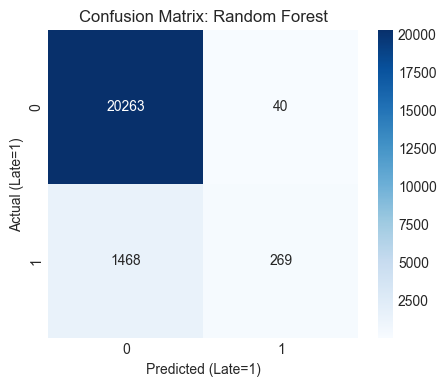

Model evaluation completed successfully
Evaluating model
--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20303
           1       0.63      0.07      0.13      1737

    accuracy                           0.92     22040
   macro avg       0.78      0.53      0.55     22040
weighted avg       0.90      0.92      0.89     22040

ROC-AUC Score: 0.7706



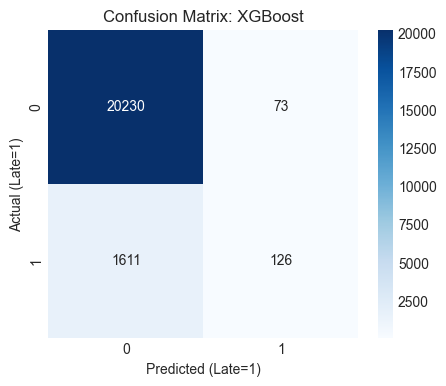

Model evaluation completed successfully
Saving model pipelines for flask
Model pipelines saved successfully


In [17]:
#main program
if __name__ == "__main__":
    # Load the datasets
    orders = pd.read_csv('archive/olist_orders_dataset.csv')
    items = pd.read_csv('archive/olist_order_items_dataset.csv')
    products = pd.read_csv('archive/olist_products_dataset.csv')
    sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
    customers = pd.read_csv('archive/olist_customers_dataset.csv')

    final_df = merge_datasets(orders, items, products, sellers, customers)
    final_df = perform_feature_engineering(final_df)

    rf_model_pipeline, xgb_model_pipeline, X_train, X_test, y_train, y_test = train_model(final_df)

    evaluate_model(rf_model_pipeline, X_test, y_test, "Random Forest")
    evaluate_model(xgb_model_pipeline, X_test, y_test, "XGBoost")


    # #Saving entire pipeline for flask
    print('Saving model pipelines for flask')
    # joblib.dump(rf_model_pipeline, 'rf_logistics_model.pkl')
    # joblib.dump(xgb_model_pipeline, 'xgb_logistics_model.pkl')
    print('Model pipelines saved successfully')
    print('='*100)

    